In [1]:
from swin_model import Swin

# Imports from CNN assignment
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from fastprogress.fastprogress import master_bar, progress_bar

from jupyterthemes import jtplot

from torch.utils.data import DataLoader, Subset, random_split
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Normalize, ToTensor, Resize
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

jtplot.style(context="talk")

In [2]:
# Dataset Utility
def eyes_data_loaders(path, batch_size, valid_batch_size=0, val_split=0.1):
    xforms = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    
    # Load dataset using ImageFolder
    dataset = ImageFolder(root=path, transform=xforms)

    # Split into training and validation
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

    # Propagate `.classes` back to subsets
    train_dataset.classes = dataset.classes
    valid_dataset.classes = dataset.classes

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, shuffle=False)

    return train_loader, valid_loader

In [3]:
# Training

def train_one_epoch(mb, loader, device, model, criterion, optimizer):

    model.train()

    losses = []

    num_batches = len(loader)
    dataiterator = iter(loader)

    for batch in progress_bar(range(num_batches), parent=mb):

        mb.child.comment = "Training"

        # Grab the batch of data and send it to the correct device
        X, Y = next(dataiterator)
        X, Y = X.to(device), Y.to(device)

        # Compute the output
        output = model(X)

        # Compute loss
        loss = criterion(output, Y)
        losses.append(loss.item())

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses

In [4]:
# Validation
def validate(mb, loader, device, model, criterion):

    model.eval()

    losses = []
    num_correct = 0

    num_classes = len(loader.dataset.classes)
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    N = len(loader.dataset)
    num_batches = len(loader)
    dataiterator = iter(loader)

    with torch.no_grad():

        batches = range(num_batches)
        batches = progress_bar(batches, parent=mb) if mb else batches
        for batch in batches:

            if mb:
                mb.child.comment = f"Validation"

            # Grab the batch of data and send it to the correct device
            X, Y = next(dataiterator)
            X, Y = X.to(device), Y.to(device)

            output = model(X)

            loss = criterion(output, Y)
            losses.append(loss.item())

            # Convert network output into predictions (one-hot -> number)
            predictions = output.argmax(dim=1)

            # Sum up total number that were correct
            comparisons = predictions == Y
            num_correct += comparisons.type(torch.float).sum().item()

            # Sum up number of correct per class
            for result, clss in zip(comparisons, Y):
                class_correct[clss] += result.item()
                class_total[clss] += 1

    accuracy = 100 * (num_correct / N)
    accuracies = {
        clss: 100 * class_correct[clss] / class_total[clss]
        for clss in range(num_classes)
    }

    return losses, accuracy, accuracies

In [5]:
# plot the loss
def update_plots(mb, train_losses, valid_losses, epoch, num_epochs):

    # Update plot data
    max_loss = max(max(train_losses), max(valid_losses))
    min_loss = min(min(train_losses), min(valid_losses))

    x_margin = 0.2
    x_bounds = [0 - x_margin, num_epochs + x_margin]

    y_margin = 0.1
    y_bounds = [min_loss - y_margin, max_loss + y_margin]

    train_xaxis = torch.linspace(0, epoch + 1, len(train_losses))
    valid_xaxis = torch.linspace(0, epoch + 1, len(valid_losses))
    graph_data = [[train_xaxis, train_losses], [valid_xaxis, valid_losses]]

    mb.update_graph(graph_data, x_bounds, y_bounds)

In [6]:
# tune the training batch size
train_batch_size = 64

data_path = "~/data/eyes"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

valid_batch_size = 128
train_loader, valid_loader = eyes_data_loaders(
    data_path, train_batch_size, valid_batch_size
)

# Input and output sizes depend on data

# Get a batch to determine input shape
X, _ = next(iter(train_loader))
input_shape = X.shape[1:]
num_features = X[0].numel()

# Get class names
class_names = train_loader.dataset.dataset.classes
num_classes = len(class_names)

print(class_names)

Using 'cuda' device.
['closed', 'down', 'left', 'right', 'straight', 'up']


In [7]:
# Create our model
model = Swin()
model.layer = nn.Linear(768, 6)
model = model.to(device)

summary(model)

# optimizer
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Layer (type:depth-idx)                   Param #
├─SwinEmbedding: 1-1                     --
|    └─Conv2d: 2-1                       4,704
|    └─Rearrange: 2-2                    --
├─ModuleList: 1-2                        --
|    └─PatchMerging: 2-3                 --
|    |    └─Linear: 3-1                  73,920
|    └─PatchMerging: 2-4                 --
|    |    └─Linear: 3-2                  295,296
|    └─PatchMerging: 2-5                 --
|    |    └─Linear: 3-3                  1,180,416
├─SwinEncoder: 1-3                       --
|    └─ShiftedWindowMSA: 2-6             --
|    |    └─Linear: 3-4                  27,936
|    |    └─Linear: 3-5                  9,312
|    └─ShiftedWindowMSA: 2-7             --
|    |    └─Linear: 3-6                  27,936
|    |    └─Linear: 3-7                  9,312
|    └─LayerNorm: 2-8                    192
|    └─MLP: 2-9                          --
|    |    └─Sequential: 3-8              74,208
├─SwinEncoder: 1-4               

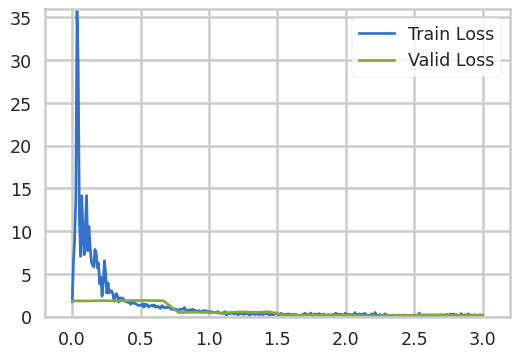

In [8]:
# Actual training of our model
num_epochs = 3

train_losses = []
valid_losses = []
accuracies = []

# progress bar from CNN playground
mb = master_bar(range(num_epochs))
mb.names = ["Train Loss", "Valid Loss"]
mb.main_bar.comment = f"Epochs"

# Loss and accuracy prior to training
vl, accuracy, _ = validate(None, valid_loader, device, model, criterion)
valid_losses.extend(vl)
accuracies.append(accuracy)

for epoch in mb:

    tl = train_one_epoch(mb, train_loader, device, model, criterion, optimizer)
    train_losses.extend(tl)

    vl, accuracy, acc_by_class = validate(mb, valid_loader, device, model, criterion)
    valid_losses.extend(vl)
    accuracies.append(accuracy)

    update_plots(mb, train_losses, valid_losses, epoch, num_epochs)

Accuracy per class
      closed: 80.9%
        down: 97.9%
        left: 96.4%
       right: 89.1%
    straight: 92.1%
          up: 98.7%


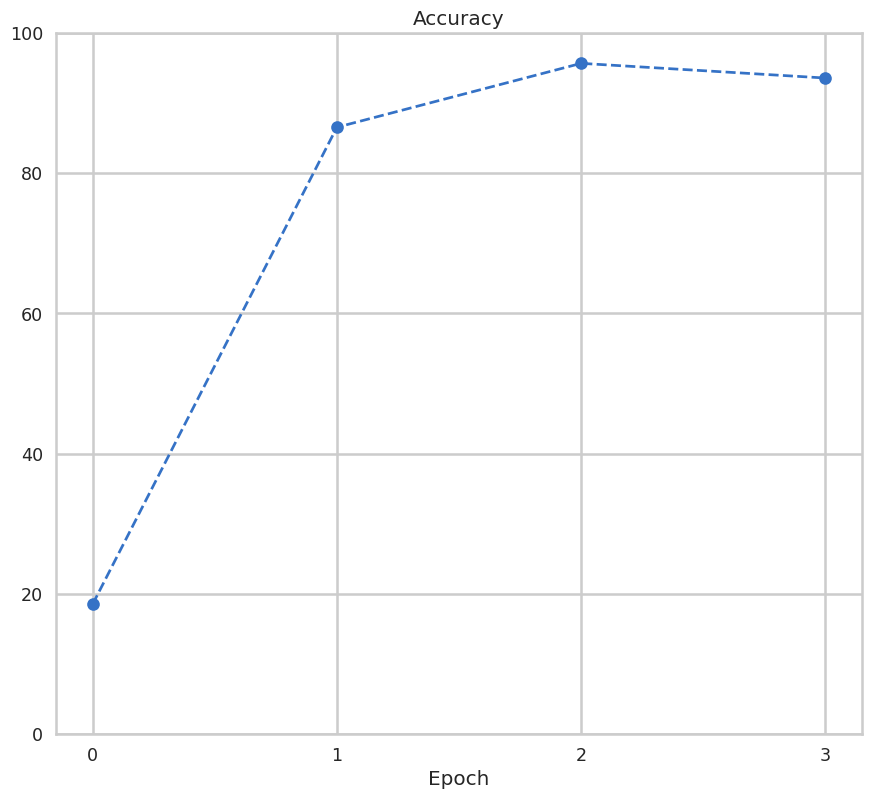

In [9]:
# Plot our accuracy
plt.plot(accuracies, '--o')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.xticks(range(num_epochs+1))
plt.ylim([0, 100])

max_name_len = max(len(name) for name in class_names)

print("Accuracy per class")
for clss in acc_by_class:
    class_name = class_names[clss]
    class_accuracy = acc_by_class[clss]
    print(f"  {class_name:>{max_name_len+2}}: {class_accuracy:.1f}%")

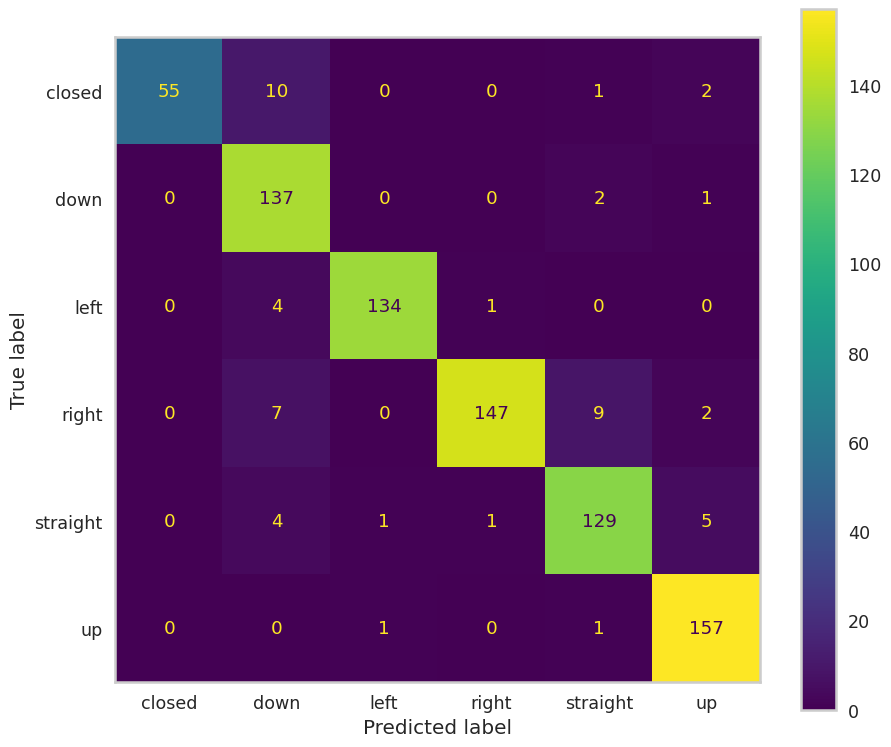

In [10]:
torch.cuda.empty_cache()

# Confusion matrix to see how we fare
y_trues = []
y_preds = []
model.to(device)
for x, y in valid_loader:
    y_trues.append(y.cpu())
    y_preds.append(model(x.to(device)).argmax(dim=1).cpu())

y_true = torch.hstack(y_trues)
y_pred = torch.hstack(y_preds)
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot();
plt.grid(False)


In [11]:
torch.save(model.state_dict(), "swin_model.pkl")